## Условия задачи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ данных

Установим CatBoost

In [1]:
pip install catboost

Подключим необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from catboost import Pool
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression

Данные хранятся в 4-х различных файлах. Сначала, прочитаем их оттуда и сохраним в соответсвующие переменные. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
contract = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Выпускной проект/final_provider/contract.csv')
personal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Выпускной проект/final_provider/personal.csv')
internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Выпускной проект/final_provider/internet.csv')
phone = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Выпускной проект/final_provider/phone.csv')

### Подготовка признаков

#### Таблица contract

Ознакомимся поподробнее с этими таблицами. Посмотрим как оргнизованы данные, выведем общую информацию о таблице, проверим хранящиеся типы данных, названия колонок. Отдельно обратим внимание на наличие пропущенных значений.

In [5]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В данной таблице хранится информация о договоре для каждого клиента (`customerID`). Сразу отметим, что пропущенных значений в этой таблице нет.

Посмотрим на названия колонок.

In [7]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

С названиями все хорошо, лишних пробелов ни в начале, ни в конце нет. Также нет нелатинских символов. Однако присутствуют прописные символы - переведем названия в нижний регистр, а чтобы отделить слова, поставим между ними нижнее подчеркивание.

In [8]:
# получаем новые названия, проставляя знак '_' перед каждой неначальной заглавной буквой
new_columns = list(map(lambda x: re.sub(r'(\B[A-Z])', r'_\1', x), contract.columns.values))

In [9]:
# приведем все буквы к нижнему регистру
new_columns = list(map(str.lower, new_columns))

In [10]:
contract.columns = new_columns
contract.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Видим, что `customerID` преобразовалось в `customer_i_d`. Подправим это вручную.

In [11]:
contract.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Поскольку у нас нет исходной информации, какая колонка какие значения хранит, мы выдвинем предположения самостоятельно, исходя из названий.

`customer_id` - код клиента<br>
`begin_date` - дата заключения договора<br>
`end_date` - дата окончания договора<br>
`type` - тип договора: оплата каждый месяц, договор на 1 год, договор на 2 года<br>
`paperless_billing` - безбумажное выставление счетов<br>
`payment_method` - способ расчета<br>
`monthly_charges` - ежемесячная плата<br>
`total_charges` - суммарная плата<br>

Посмотрим, что у нас нет повторяющихся клиентов.

In [12]:
contract['customer_id'].value_counts()

4299-OPXEJ    1
6532-YLWSI    1
9926-PJHDQ    1
0310-SUCIN    1
0164-XAIRP    1
             ..
6292-TOSSS    1
9919-FZDED    1
9919-KNPOO    1
6260-ONULR    1
8603-IJWDN    1
Name: customer_id, Length: 7043, dtype: int64

Посмотрим на данные в колонке `begin_date`

In [13]:
contract['begin_date'].value_counts()

2014-02-01    366
2019-11-01    237
2019-09-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

В колонке `end_date` присутствует вспомогательное значение *No*, которое указывает, что у контракта нет даты его окончания, то есть он еще не закончился.

In [14]:
contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Однако у нас есть еще 4 значения. Данные сейчас представлены в виде строк. Оставим пока все в таком виде. При дальнейшем анализе решим, как лучше обработать данные колонки.

Рассмотрим остальные колонки.

In [15]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Посмотрим более наглядно.

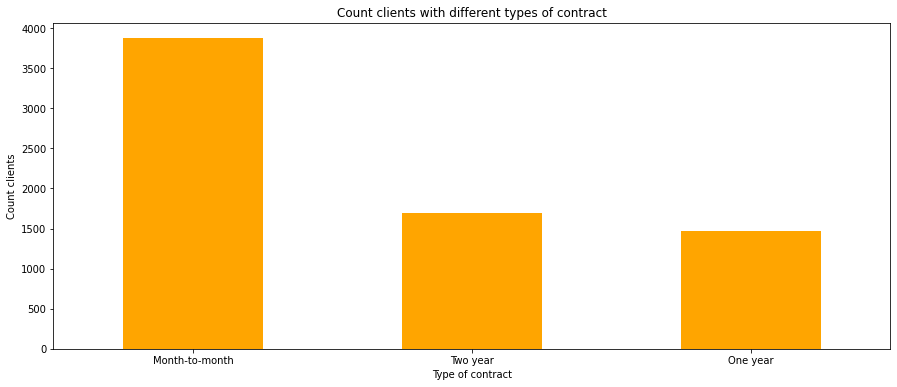

In [16]:
(contract
    .groupby(by='type')['customer_id']
    .count()
    .sort_values(ascending=False)
    .plot(rot=0, kind='bar', color='orange', xlabel='Type of contract', ylabel='Count clients',
          title='Count clients with different types of contract', legend=0, figsize=(15, 6))
)

Здесь у нас всего 3 значения. Это категориальный признак. Необходимо будет учесть это при подготовке признаков для модели.

In [17]:
contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Также категориальный признак, здесь всего 2 значения.

In [18]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

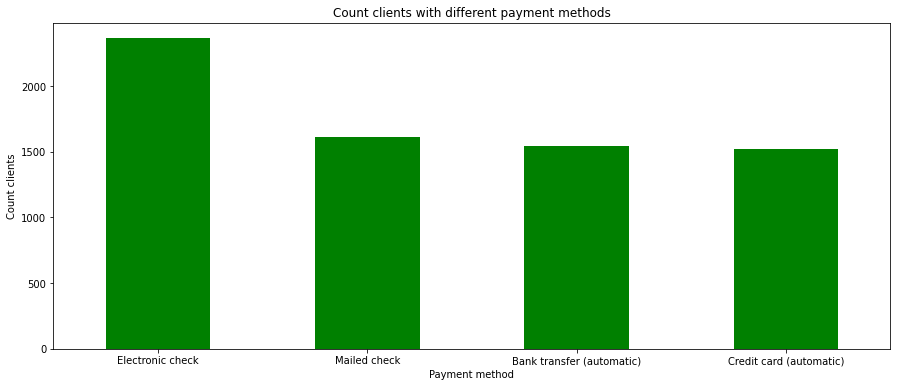

In [19]:
(contract
    .groupby(by='payment_method')['customer_id']
    .count()
    .sort_values(ascending=False)
    .plot(rot=0, kind='bar', color='green', xlabel='Payment method', ylabel='Count clients',
          title='Count clients with different payment methods', legend=0, figsize=(15, 6))
)

Такая же ситуация.

Последние две колонки это количественные переменные.

Переведем колонку `total_charges` в тип данных float. При этом некорректные значения принудительно заменятся на NaN. Поскольку это значение, судя по названию несет смысл (общие расходы), и нигде не сказано, что это только лишь месячные расходы умноженное на количество месяцев, то заполнить эту колонку какими-то значениями не представляется возможным. Посмотрим сколько всего пропусков получится.

In [20]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [21]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Пропущено всего 11 значений, не так много по сравнению с общим количесвтом строк. Удалим эти строки.

In [22]:
contract = contract.dropna()

Проверим внесенные изменения.

In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


Итого, колонки `type`, `paperless_billing` и `payment_method` содержат категориальные переменные, необходимо учесть это при формировании признаков модели. `monthly_charges` и `total_charges` - количественные переменные. `begin_date` и `end_date` - это данные формата дата/время, но их необходимо обработать отдельно, сделаем это позже.

In [24]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


#### Таблица personal

Ознакомимся соследующей таблицей - персональные данные для каждого клиента.

In [25]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Выведем общую информацию по таблице.

In [26]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Также заметим, что здесь нет пропусков. Количество строк, столько же, сколько и договоров.

Проверим названия столбцов.

In [27]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [28]:
new_columns = list(map(lambda x: re.sub(r'(\B[A-Z])', r'_\1', x), personal.columns.values))
new_columns = list(map(str.lower, new_columns))
personal.columns = new_columns
personal.columns

Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [29]:
personal.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Опишем, что хранится в каждой колонке.

`customer_id` - код клиента<br>
`gender` - пол клиента<br>
`senior_citizen` - является ли клиент пенсионером<br>
`partner` - есть ли партнер<br>
`dependents` - есть ли люди на попечительтсве<br>

In [30]:
personal['customer_id'].value_counts()

4299-OPXEJ    1
6532-YLWSI    1
9926-PJHDQ    1
0310-SUCIN    1
0164-XAIRP    1
             ..
6292-TOSSS    1
9919-FZDED    1
9919-KNPOO    1
6260-ONULR    1
8603-IJWDN    1
Name: customer_id, Length: 7043, dtype: int64

У нас 7043 разных клиента, одинаковых записей в таблице нет.

In [31]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Всего два пола - категориальная переменная.

Посмотрим остальные колонки.

In [32]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [33]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [34]:
personal['dependents'].value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

Все 3 колонки - категориальные признаки, учтем это в дальнейшем.

In [35]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [36]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


#### Таблица internet

Рассмотрим таблицу `internet` - информация об интеренет услугах для каждого клиента.

In [37]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [38]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков в данной таблице нет. Однако количество клиентов, которые пользуются данной услугой (5517), меньше, чем общее количесвто клиентов (7043). Скорее всего, кто-то пользуются только услугами телефонии.

In [39]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Проведем вышеописанные операции над названиями колонок.

In [40]:
new_columns = list(map(lambda x: re.sub(r'(\B[A-Z])', r'_\1', x), internet.columns.values))
new_columns = list(map(str.lower, new_columns))
internet.columns = new_columns
internet.columns

Index(['customer_i_d', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')

In [41]:
internet.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
internet.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Определим, что хранится в колонках.

`customer_id` - код клиента<br>
`internet_service` - тип интернет подключения<br>
`online_security` - подключение блокировки небезопасных сайтов<br>
`online_backup` - подключение облачного хранилища файлов для резервного копирования данных<br>
`device_protection` - подключение антивируса<br>
`tech_support` - подключение выделенной линии технической поддержки<br>
`streaming_tv` - подключение стримингового телевидения<br>
`streaming_movies` - подключение каталога фильмов<br>

In [42]:
print(internet['internet_service'].value_counts())
print('-' * 40)
print(internet['online_security'].value_counts())
print('-' * 40)
print(internet['online_backup'].value_counts())
print('-' * 40)
print(internet['device_protection'].value_counts())
print('-' * 40)
print(internet['tech_support'].value_counts())
print('-' * 40)
print(internet['streaming_tv'].value_counts())
print('-' * 40)
print(internet['streaming_movies'].value_counts())

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64
----------------------------------------
No     3498
Yes    2019
Name: online_security, dtype: int64
----------------------------------------
No     3088
Yes    2429
Name: online_backup, dtype: int64
----------------------------------------
No     3095
Yes    2422
Name: device_protection, dtype: int64
----------------------------------------
No     3473
Yes    2044
Name: tech_support, dtype: int64
----------------------------------------
No     2810
Yes    2707
Name: streaming_tv, dtype: int64
----------------------------------------
No     2785
Yes    2732
Name: streaming_movies, dtype: int64


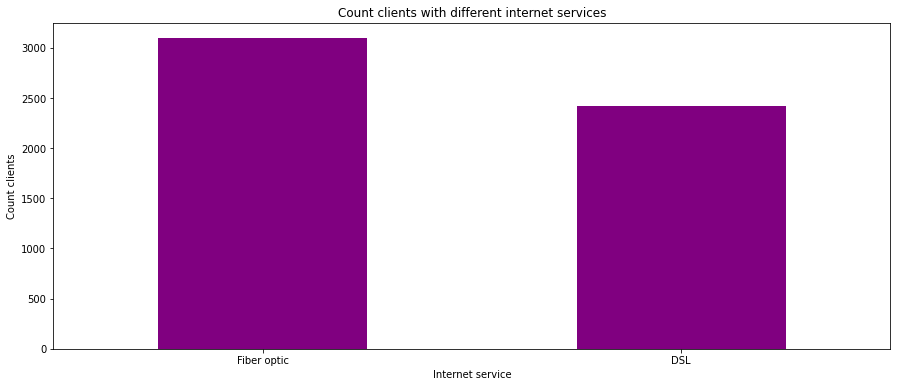

In [43]:
(internet
    .groupby(by='internet_service')['customer_id']
    .count()
    .sort_values(ascending=False)
    .plot(rot=0, kind='bar', color='purple', xlabel='Internet service', ylabel='Count clients',
          title='Count clients with different internet services', legend=0, figsize=(15, 6))
)

Как мы видим, это все категориальные переменные. Помимо типа интернет подключения, значения сводятся к *No* и *Yes*.

In [44]:
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [45]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


#### Таблица phone

Рассмотрим таблицу `phone` - информация об услугах телефонии.

In [46]:
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [47]:
phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [48]:
new_columns = list(map(lambda x: re.sub(r'(\B[A-Z])', r'_\1', x), phone.columns.values))
new_columns = list(map(str.lower, new_columns))
phone.columns = new_columns
phone.columns

Index(['customer_i_d', 'multiple_lines'], dtype='object')

In [49]:
phone.rename(columns={'customer_i_d': 'customer_id'}, inplace=True)
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

Определим, что хранится в колонках.

`customer_id` - код клиента<br>
`multiple_lines` - подключение телефонного аппарата к нескольким линиям одновременно<br>

In [50]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В данной таблице пропусков нет. Однако и здесь, количество пользователей меньше (6361), чем всего пользователей (7043). Кто-то пользуется и интернетом и телефоном.

In [51]:
print(phone['multiple_lines'].value_counts())

No     3390
Yes    2971
Name: multiple_lines, dtype: int64


Это категориальная переменная.

In [52]:
phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [53]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Анализ данных

Мы провели предобработку данных. Мы ознакомились с ними, убедились что нет пропущенных значений, в колонках хранятся ожидаемые типы данных. Однако стоит учитывать, что таблицы были получены из разных источников. Во всех них есть колонка customer_id код клиента. Наша задача сейчас убедиться, что эти данные можно скомпоновать в одну итоговую таблицу со всей информацией по клиенту, для каждого контракта есть информация по клиенту и т.д.

Главной таблицей является `personal`, именно здесь хранятся персональные данные о клиентах, для которых заключается контракты. Так что если клиента нет в этой таблице, рассматривать его в таблице `contract` смысла не имеет. Также и наоборот, если нет контракта, рассматривать нечего. Объеденим эти две таблицы по столбцу *customer_id*.

In [54]:
personal_contract = personal.merge(contract, on='customer_id', how='inner') 

In [55]:
personal_contract.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Проверим, что после объединения у нас не появилось нигде лишних значений NaN.

In [56]:
personal_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   int64  
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   begin_date         7032 non-null   object 
 6   end_date           7032 non-null   object 
 7   type               7032 non-null   object 
 8   paperless_billing  7032 non-null   object 
 9   payment_method     7032 non-null   object 
 10  monthly_charges    7032 non-null   float64
 11  total_charges      7032 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 714.2+ KB


In [57]:
personal_contract.isnull().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

Дальше в таблицах `internet` и `phone` строк меньше, чем в предыдущих таблицах, а значит будут пропущенные значения. Также стоит отметить, что сам факт нахождения в таблице означает использование этой услуги. Таким образом, если мы присоеденим эти табицы без дополнительной информации, то в дальнейшем будем некорректно обрабатывать данные. Чтобы избежать такой ситуации, заполним пропущенные колонки после объединения значением *no_info*. Таким образом, введем еще одну категорию в рассматриваемые признаки.

In [58]:
personal_contract_internet = personal_contract.merge(internet, on='customer_id', how='left') 

In [59]:
personal_contract_internet.isnull().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
dtype: int64

Видно что образовались NaN, заменим их на *no_info*.

In [60]:
personal_contract_internet['internet_service'] = personal_contract_internet['internet_service'].fillna('No') # все же оставлю доп категорию
personal_contract_internet['online_security'] = personal_contract_internet['online_security'].fillna('No')
personal_contract_internet['online_backup'] = personal_contract_internet['online_backup'].fillna('No')
personal_contract_internet['device_protection'] = personal_contract_internet['device_protection'].fillna('No')
personal_contract_internet['tech_support'] = personal_contract_internet['tech_support'].fillna('No')
personal_contract_internet['streaming_tv'] = personal_contract_internet['streaming_tv'].fillna('No')
personal_contract_internet['streaming_movies'] = personal_contract_internet['streaming_movies'].fillna('No')

Тоже самое для `phone`.

In [61]:
total = personal_contract_internet.merge(phone, on='customer_id', how='left') 

In [62]:
total.isnull().sum()

customer_id            0
gender                 0
senior_citizen         0
partner                0
dependents             0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
monthly_charges        0
total_charges          0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
multiple_lines       680
dtype: int64

In [63]:
total['multiple_lines'] = total['multiple_lines'].fillna('No')

In [64]:
total.isnull().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

В итоге мы получили одну общую таблицу со всеми признаками.

In [65]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   int64  
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   begin_date         7032 non-null   object 
 6   end_date           7032 non-null   object 
 7   type               7032 non-null   object 
 8   paperless_billing  7032 non-null   object 
 9   payment_method     7032 non-null   object 
 10  monthly_charges    7032 non-null   float64
 11  total_charges      7032 non-null   float64
 12  internet_service   7032 non-null   object 
 13  online_security    7032 non-null   object 
 14  online_backup      7032 non-null   object 
 15  device_protection  7032 non-null   object 
 16  tech_support       7032 

## Построение и обучение модели

У нас есть таблица с данными, теперь нам необходимо найти модель, которая будет прогнозировать отток клиентов. Для этого нам необходимо выделить из данных целевой признак. У нас в данных есть колонка `end_date`. В которой хранятся либо значение даты прекращения контракта (означает, что клиент ушел), либо значени *No* (означает, что клиент не ушел, и котракт все еще действует). Перед нами задача бинарной классификации. На основе выше сказанного, создадим колонку в которой будет хранится значение 1, если клиент ушел, и 0 - если нет.

In [66]:
total['end_date'].value_counts()

No                     5163
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [67]:
def form_outflow(row):
    outflow = 0 if row['end_date']=='No' else 1
    return outflow

In [68]:
total['outflow'] = total.apply(form_outflow, axis=1)

In [69]:
total.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,outflow
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,1


В колонке `outflow` хранится наш целевой признак.

Выделим отдельно признаки и целевой признак

In [70]:
target = total['outflow']
features = total.drop('outflow', axis=1)

Помним, что у нас есть еще колонка с датой (*begin_date*). Как было выяснено при подготовке данных, там нет пропусков. Приведем для начала к верному типу.

In [71]:
features['begin_date'] = pd.to_datetime(features['begin_date'], format='%Y-%m-%d')

Учтем, что нам также дана дата выгрузки из базы - 1 февраля 2020

In [72]:
load_date = '2020-02-01'
load_date = pd.to_datetime(load_date, format='%Y-%m-%d')

In [73]:
def form_lifetime(row):
    lifetime = 0
    begin_date_in_sec = 0
    end_date_in_sec = 0
    
    if row['end_date'] == 'No':
        begin_date_in_sec = row['begin_date'].timestamp()
        end_date_in_sec = load_date.timestamp()
    else:
        begin_date_in_sec = row['begin_date'].timestamp()
        end_date = pd.to_datetime(row['end_date'], format='%Y-%m-%d')
        end_date_in_sec = end_date.timestamp()
    
    lifetime = end_date_in_sec - begin_date_in_sec
    return lifetime

In [74]:
features['lifetime'] = features.apply(form_lifetime, axis=1)

Удалим колонки, которые не будем использовать при обучении модели. Из *begin_date* и *end_date* получили признак *lifetime* (количественный). Также *end_date* - уже использована для целевого признака. *customer_id* - уникальный для каждого клиента, с помощью него мы соединяли таблицы, но он нам не поможет в дальнейшем.

In [77]:
features = features.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

В итогу получили следующую таблицу признаков.

In [78]:
features.head()

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,lifetime
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No,2678400.0
1,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,89510400.0
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,5270400.0
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No,118454400.0
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,5270400.0


В качестве модели в дальнейшем будем использовать классификатор из библиотеки CatBoost. В основе этой модели лежит градиентный бустинг.

Зафиксируем отдельно в переменную параметр рандомизации.

In [79]:
RAND_SEED = 12345

Выделим тренировочную, валидационную и тестовую выборки в стандартном соотношении 60:20:20. При этом используем параметр стратификации, чтобы сделать распределение долей классов в целевом признаке одинаковым для всех выборок.

In [80]:
# отделим 40% данных для проверочных выборок
features_train, features_check, target_train, target_check = train_test_split(
        features, target, test_size=0.4, random_state=RAND_SEED, stratify=target)

In [81]:
# определим 50% данных для валидационной выборки и 50% для тестовой выборки (из проверочное выборки)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_check, target_check, test_size=0.5, random_state=RAND_SEED, stratify=target_check)

В наших признаках есть количественные переменные. Все значение разных порядков. Для того чтобы они давали одинаковое влияние в обучении модели их необходимо масштабировать. Сделаем это с помощью стандартизации.

In [82]:
numerical_cols = ['monthly_charges', 'total_charges', 'lifetime']

In [83]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numerical_cols])

features_train[numerical_cols] = scaler.transform(features_train[numerical_cols])
features_valid[numerical_cols] = scaler.transform(features_valid[numerical_cols])
features_test[numerical_cols] = scaler.transform(features_test[numerical_cols])

Заметим, что в тренировочных данных у нас присутствует дисбаланс классов в целевом признаке. Это может повлиять на качество обучения. Поэтому попробуем устранить дисбаланс путем увеличения выборки для положительных объектов.

In [84]:
print(target_train.value_counts(normalize=True))

0    0.734297
1    0.265703
Name: outflow, dtype: float64


In [85]:
def upsample(rand_seed, features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rand_seed)
    
    return features_upsampled, target_upsampled

In [86]:
features_train_upsampled, target_train_upsampled = upsample(RAND_SEED, features_train, target_train, 3)

In [87]:
print(target_train_upsampled.value_counts(normalize=True))

1    0.520508
0    0.479492
Name: outflow, dtype: float64


Теперь выборка у нас более-менее сбалансированная.

In [88]:
features_train.head()

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,lifetime
5579,Male,0,No,No,Month-to-month,Yes,Mailed check,-0.510851,-0.985802,DSL,No,No,Yes,No,No,No,No,-1.282000
1585,Female,0,Yes,Yes,Two year,No,Electronic check,-1.514851,-0.450093,No,No,No,No,No,No,No,No,1.248969
5655,Female,1,No,No,Month-to-month,Yes,Credit card (automatic),0.647227,-0.625825,Fiber optic,No,No,Yes,No,No,Yes,No,-0.914688
1329,Male,0,No,No,One year,Yes,Mailed check,-0.983029,-0.236088,DSL,Yes,No,No,Yes,No,No,No,0.719449
570,Male,1,No,No,Two year,No,Bank transfer (automatic),-0.181155,0.207366,DSL,No,Yes,No,Yes,No,No,Yes,0.597459


CatBoost умеет работать с категориальными переменными по умолчанию, без дополнительной их подготовки. Выделим из таблицы названия категориальных переменных.

In [89]:
cat_features = ['gender', 'senior_citizen', 'partner', 'dependents', 'type',
       'paperless_billing', 'payment_method', 'internet_service', 'online_security', 
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
       'streaming_movies', 'multiple_lines']

В качестве метрики возьмем значение AUC-ROC - площадь под ROC-кривой.

In [90]:
model = CatBoostClassifier(eval_metric='AUC', verbose = 3000)

Подготовим тренировочную выборку в виде удобном для CatBoost.

In [91]:
train_pool = Pool(data=features_train_upsampled, label=target_train_upsampled, cat_features=cat_features)

Посмотрим на качество модели на разных значениях гиперпараметров. Для этого воспользуемся поиском по сетке.

In [92]:
grid_cbc = {'iterations': [4000, 5000],
            'learning_rate': [0.04],
            'depth': [2, 3]}

In [93]:
result = model.grid_search(param_grid=grid_cbc, X=train_pool, verbose=1000)

0:	test: 0.7345276	best: 0.7345276 (0)	total: 52.8ms	remaining: 3m 30s
3000:	test: 0.9368885	best: 0.9369389 (2997)	total: 10.4s	remaining: 3.47s
3999:	test: 0.9445486	best: 0.9445750 (3996)	total: 13.9s	remaining: 0us

bestTest = 0.9445749966
bestIteration = 3996

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9445750	best: 0.9445750 (0)	total: 14s	remaining: 42s
0:	test: 0.7345276	best: 0.7345276 (0)	total: 3.64ms	remaining: 18.2s
3000:	test: 0.9368885	best: 0.9369389 (2997)	total: 10.2s	remaining: 6.8s
4999:	test: 0.9483757	best: 0.9483757 (4999)	total: 17s	remaining: 0us

bestTest = 0.9483756642
bestIteration = 4999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.8090242	best: 0.8090242 (0)	total: 5.11ms	remaining: 20.4s
3000:	test: 0.9575069	best: 0.9575069 (3000)	total: 13.3s	remaining: 

Посмотрим какие параметры подобрались для наилучшей модели.

In [94]:
model.get_params()

{'depth': 3,
 'eval_metric': 'AUC',
 'iterations': 5000,
 'learning_rate': 0.04,
 'verbose': 3000}

Подготовим валидационную выборку.

In [95]:
valid_pool = Pool(data=features_valid, label=target_valid, cat_features=cat_features)

Мы уже можем пользоваться нашей моделью. Она уже обучена на оптимальных гиперпараметрах после grid_search. Однако, мы хотим посмотреть на качество на валидационной выборке.

In [96]:
model.fit(train_pool, eval_set=valid_pool, verbose=400)

0:	test: 0.8089621	best: 0.8089621 (0)	total: 7.95ms	remaining: 39.7s
400:	test: 0.8804953	best: 0.8808373 (382)	total: 1.96s	remaining: 22.5s
800:	test: 0.8907008	best: 0.8907008 (800)	total: 3.92s	remaining: 20.6s
1200:	test: 0.9019582	best: 0.9019582 (1198)	total: 5.92s	remaining: 18.7s
1600:	test: 0.9046579	best: 0.9046942 (1599)	total: 7.92s	remaining: 16.8s
2000:	test: 0.9084769	best: 0.9085753 (1901)	total: 9.96s	remaining: 14.9s
2400:	test: 0.9100754	best: 0.9101117 (2399)	total: 12s	remaining: 13s
2800:	test: 0.9112258	best: 0.9116896 (2732)	total: 14s	remaining: 11s
3200:	test: 0.9120575	best: 0.9120912 (3199)	total: 16s	remaining: 8.98s
3600:	test: 0.9131586	best: 0.9131819 (3585)	total: 18s	remaining: 7s
4000:	test: 0.9135446	best: 0.9136405 (3742)	total: 20.1s	remaining: 5.01s
4400:	test: 0.9138089	best: 0.9142079 (4202)	total: 22.1s	remaining: 3.01s
4800:	test: 0.9146043	best: 0.9146199 (4798)	total: 24.2s	remaining: 1s
4999:	test: 0.9148090	best: 0.9148479 (4984)	total: 

Получим вероятности класса *1* для тестовой выборки. С помощью стандартной функции найдем значение метрики auc-roc.

In [97]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('test_auc_roc =', test_auc_roc)

test_auc_roc = 0.9166489794016701


Наше значение получилось > 0.917. Это довольно неплохой результат.

Для наглядности построим кривую ошибок. Посмотрим как она располагается относительно случайной модели.

<Figure size 576x576 with 0 Axes>

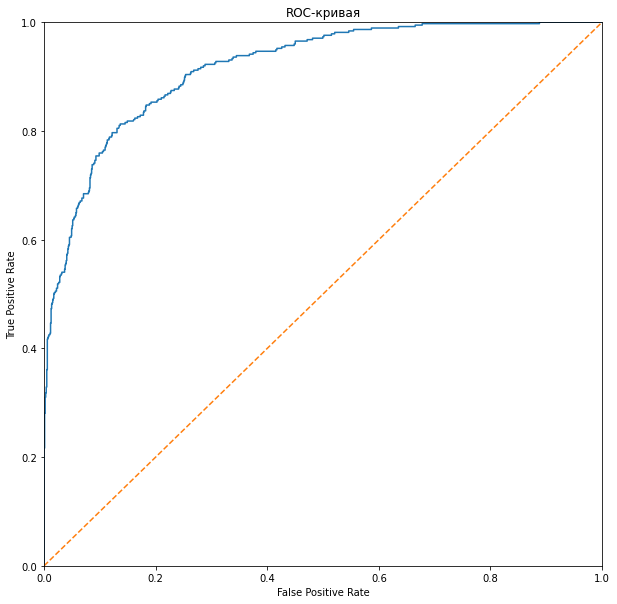

In [98]:
# Построим ROC-кривую
plt.figure(figsize=(8,8))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(10, 10))

# Наша ROC-кривая
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

Из графика видно, что модель предсказывает качественно (кривая для найденной модели находится выше, чем кривая для случайной модели).

Измерим также значение доли правильных ответов (*accuracy*).

In [99]:
predictions_test = model.predict(features_test)
test_accuracy = accuracy_score(target_test, predictions_test)
print('test_accuracy =', test_accuracy)

test_accuracy = 0.8557213930348259


Доля правильных ответов также имеет высокий показатель.

Также стоит посмотреть на важность принаков, которые использовались при обучении модели.

In [100]:
model.feature_importances_

array([ 0.87030979,  0.68360905,  0.29089144,  0.73797002,  5.09924051,
        0.83182488,  1.53025942, 11.28704696, 12.67028208,  2.06162878,
        0.47233348,  0.49394794,  0.35375615,  0.66228004,  0.55429077,
        0.76620424,  0.35878233, 60.27534214])

In [101]:
model.feature_names_

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'lifetime']

In [102]:
feature_importance_data = {'feature_name': model.feature_names_, 'importance': model.feature_importances_}
feature_importance_df = pd.DataFrame(data=feature_importance_data)

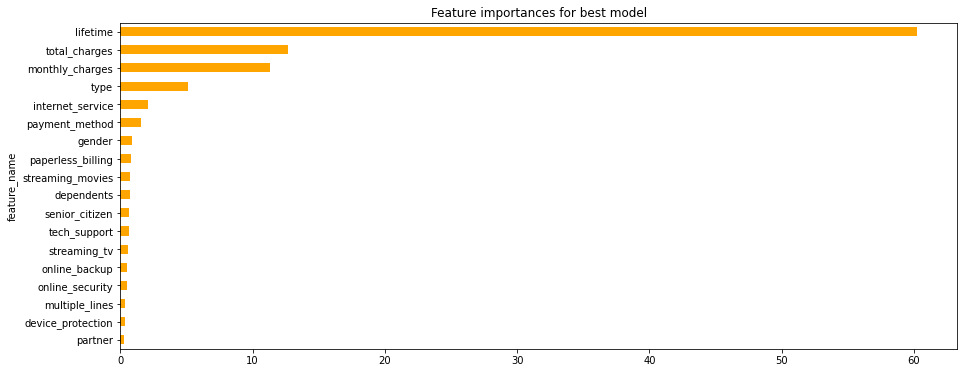

In [103]:
(feature_importance_df
    .sort_values(by='importance')
    .plot(x='feature_name', y='importance', kind='barh', color='orange', title='Feature importances for best model', legend=0, figsize=(15, 6))
)

Как видно из графика самыми важными признакаим являются количественные. Наибольшее влияние вносит время жизни клиента, а далее идут непосредственно  признаки, касающиеся цен за услуги. Стоит отметить, что также тип договора(оплата каждый месяц, договор на 1 год, договор на 2 года) также играет непоследнюю роль, на этот признак стоит обращать внимание.

## Вывод

В данной работе мы исследовали данные оператора связи и  учились прогнозировать на них отток клиентов.<br>
В первую очередь необходимо было подготовить данные. Мы ознакомились с ними, определили какие данные хранятся в таблицах, отметили категориальные и количесвтенные переменные. Далее мы объединили все данные в единую таблицу и избавились от пропусков, которые получились в результате этой операции.<br>
После этого мы перешли к построению и обучению модели. Выделили целевой признак - ушел/не ушел клиент, на основе одной из колонок в наших данных. Далее мы удалили лишние столбцы и разделили данные на тренировочную, валидационную и тестовые выборки. После чего отмасштабировали количесвтенные признаки и устранили дисбаланс для целевого признака на тренировочной выборке. Затем, с помощью поиска по сетке подобрали оптимальные параметры для классификатора из библиотеки CatBoost, обучили модель. В итоге получили вероятности класса 1 для тестовой выборка и посчитали значение метрики auc-roc. Для тестовой выборки она составила 0.917. Также была посчтиана доля правильных ответов, ее значение получилось 0.856.